# Hiệu chỉnh 1 camera (kết quả hiển thị trong cửa sổ nên chạy code mới thấy kết quả)

In [ ]:
import os
import urllib.request
import cv2
import numpy as np
import glob

# ------------------------------
# Bước 1: Tải ảnh mẫu bàn cờ
# ------------------------------
os.makedirs("calib_images", exist_ok=True)

img_urls = [
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left02.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left03.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left04.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left05.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left06.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left07.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left08.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right01.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right02.jpg"
]

for i, url in enumerate(img_urls):
    filename = f"calib_images/img_{i+1:02}.jpg"
    urllib.request.urlretrieve(url, filename)

print("==== Đã tải xong ảnh bàn cờ vào thư mục calib_images/ ====\n")

# ------------------------------
# Bước 2: Tìm góc bàn cờ và hiển thị từng ảnh 
# ------------------------------


pattern_size = (9, 6)

objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

objpoints = []  # Điểm 3D
imgpoints = []  # Điểm 2D

# Thêm cờ ở đây giúp tăng khả năng phát hiện của thuật toán trên bàn cờ vua
chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE

images = glob.glob('calib_images/*.jpg')
successful_imgs = 0
failed_imgs = 0
print("==== Tìm và hiển thị góc bàn cờ trên các ảnh ====\n")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Tìm góc bàn cờ
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, chessboard_flags)

    if ret:
        # Thêm điểm đối tượng cho mỗi ảnh thành công
        objpoints.append(objp)

        # Tinh chỉnh vị trí góc
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Thêm điểm ảnh cho mỗi ảnh thành công
        imgpoints.append(corners_refined)

        # Vẽ và hiển thị góc
        img_copy = img.copy()
        cv2.drawChessboardCorners(img_copy, pattern_size, corners_refined, ret)
        print(f"Phát hiện thành công góc ở ảnh: {fname}")
        cv2.imshow("Chessboard Corners", img_copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        successful_imgs += 1
    else:
        print(f"Không phát hiện đủ góc ở ảnh: {fname}")
        failed_imgs += 1

print(f"\nTổng kết: {successful_imgs} ảnh thành công, {failed_imgs} ảnh thất bại")

if successful_imgs < 3:
    print("Không đủ ảnh để hiệu chỉnh camera (cần ít nhất 3 ảnh thành công)")
else:

    # ------------------------------
    # Bước 3: Hiệu chỉnh camera
    # ------------------------------

    print("\n==== Kết quả hiệu chỉnh camera ====\n")

    image_size = gray.shape[::-1]

    # IN THÔNG TIN KIỂM TRA
    print(f"Số lượng điểm đối tượng: {len(objpoints)}")
    print(f"Số lượng điểm ảnh: {len(imgpoints)}")
    print(f"Kích thước objpoints[0]: {objpoints[0].shape}")
    print(f"Kích thước imgpoints[0]: {imgpoints[0].shape}")

    # chúng ta sẽ kiểm tra xem các số lượng điểm 
    for i in range(len(objpoints)):
        print(f"Ảnh {i+1}: {objpoints[i].shape[0]} điểm đối tượng, {imgpoints[i].shape[0]} điểm ảnh")

    # Thực hiện hiệu chỉnh camera
    try:
        ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, image_size, None, None
        )

        print("\nMa trận nội tại camera:")
        print(camera_matrix)
        print("\nHệ số méo ống kính:")
        print(dist_coeffs)

        mean_error = 0
        for i in range(len(objpoints)):
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
            mean_error += error
        mean_error /= len(objpoints)
        print("\nSai số tái chiếu trung bình: {:.4f} pixel".format(mean_error))

        # ------------------------------
        # Bước 4: Sửa méo ảnh (Undistort)
        # ------------------------------

        print("\n==== Sửa méo ảnh (Undistort) ====\n")
        img = cv2.imread(images[0])
        h, w = img.shape[:2]
        new_cam_mtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))

        undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_cam_mtx)

        # Hiển thị ảnh gốc và ảnh đã sửa méo (so sánh theo chiều ngang)
        comparison = np.hstack((img, undistorted_img))
        print("So sánh ảnh gốc (trái) và ảnh đã sửa méo (phải):")
        cv2.imshow("Compare distort picture", comparison)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        cv2.imwrite('undistorted_result.png', undistorted_img)
        print("Ảnh đã được sửa méo và lưu tại: undistorted_result.png")

        np.savez('calibration_result.npz',
                 camera_matrix=camera_matrix,
                 dist_coeffs=dist_coeffs,
                 rvecs=rvecs,
                 tvecs=tvecs)
        print("\nĐã lưu kết quả hiệu chuẩn tại: calibration_result.npz")

    except Exception as e:
        print(f"Lỗi trong quá trình hiệu chỉnh camera: {e}")
        print("Vui lòng kiểm tra kỹ các điểm đối tượng và điểm ảnh để đảm bảo tương thích")


==== Đã tải xong ảnh bàn cờ vào thư mục calib_images/ ====

==== Tìm và hiển thị góc bàn cờ trên các ảnh ====

Phát hiện thành công góc ở ảnh: calib_images\img_01.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_02.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_03.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_04.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_05.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_06.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_07.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_08.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_09.jpg
Phát hiện thành công góc ở ảnh: calib_images\img_10.jpg

Tổng kết: 10 ảnh thành công, 0 ảnh thất bại

==== Kết quả hiệu chỉnh camera ====

Số lượng điểm đối tượng: 10
Số lượng điểm ảnh: 10
Kích thước objpoints[0]: (54, 3)
Kích thước imgpoints[0]: (54, 1, 2)
Ảnh 1: 54 điểm đối tượng, 54 điểm ảnh
Ảnh 2: 54 điểm đối tượng, 54 điểm ảnh
Ảnh 3: 54 điểm đối tượng, 54 điểm ảnh
Ảnh 4: 54 điể

# Hiệu chỉnh 2 camera (kết quả hiển thị trong cửa sổ nên chạy code mới thấy kết quả)

In [ ]:
import os, urllib.request, cv2, numpy as np, glob

# --- Bước 1: Tải ảnh gốc ---
os.makedirs("stereo/left", exist_ok=True)
os.makedirs("stereo/right", exist_ok=True)

# Tải các cặp ảnh để tiến hành hiệu chỉnh 2 camera
for i in range(1, 10):
    idx = f"{i:02}"
    try:
        urllib.request.urlretrieve(
            f"https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left{idx}.jpg",
            f"stereo/left/left{idx}.png"
        )
        print(f"Đã tải: stereo/left/left{idx}.png")
    except Exception as e:
        print(f"Lỗi khi tải left{idx}.jpg: {e}")
    try:
        urllib.request.urlretrieve(
            f"https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right{idx}.jpg",
            f"stereo/right/right{idx}.png"
        )
        print(f"Đã tải: stereo/right/right{idx}.png")
    except Exception as e:
        print(f"Lỗi khi tải right{idx}.jpg: {e}")

# nếu như không đủ ảnh thì tải thêm các ảnh bổ sung dưới đây
extra_urls_left = [
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left11.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left12.jpg"
]

extra_urls_right = [
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right11.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right12.jpg"
]

num_original = 9  

# Tải ảnh bổ sung cho camera trái
for i, url in enumerate(extra_urls_left):
    # đánh số liên tiếp cho ảnh
    file_index = num_original + i + 1  
    filename = f"stereo/left/left{file_index:02}.png"
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Đã tải thêm: {filename}")
    except Exception as e:
        print(f"Lỗi khi tải {url}: {e}")

# Tải ảnh bổ sung cho camera phải
for i, url in enumerate(extra_urls_right):
    file_index = num_original + i + 1
    filename = f"stereo/right/right{file_index:02}.png"
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Đã tải thêm: {filename}")
    except Exception as e:
        print(f"Lỗi khi tải {url}: {e}")

print("Đã tải xong ảnh mẫu stereo (bao gồm ảnh gốc và ảnh bổ sung).")

# --- Bước 2: Hiệu chỉnh stereo ---

img_paths_left = sorted(glob.glob('stereo/left/*.png'))
img_paths_right = sorted(glob.glob('stereo/right/*.png'))

# các tham số nội tại ở đây đã trích xuất từ kết quả của việc chạy hiệu chỉnh camera trước đó
camera_matrix = np.array([
    [534.45672467,   0.        , 341.4072105 ],
    [  0.        , 534.87729101, 233.69658446],
    [  0.        ,   0.        ,   1.        ]
])

dist_coeffs = np.array([
    [-0.31439384, 0.25740347, 0.00140939, 0.00005816, -0.25081657]
])

camera_matrix_L = camera_matrix.copy()
dist_coeffs_L = dist_coeffs.copy()
camera_matrix_R = camera_matrix.copy()
dist_coeffs_R = dist_coeffs.copy()

# Định nghĩa kích thước pattern (ví dụ: bàn cờ có 9 góc trên mỗi hàng và 6 hàng)
pattern_size = (9, 6)
objp = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

objpoints = []       # Điểm 3D của mẫu
imgpoints_left = []  # Điểm 2D từ ảnh trái
imgpoints_right = [] # Điểm 2D từ ảnh phải

# Duyệt qua từng cặp ảnh
for imgL_path, imgR_path in zip(img_paths_left, img_paths_right):
    imgL = cv2.imread(imgL_path)
    imgR = cv2.imread(imgR_path)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    retL, cornersL = cv2.findChessboardCorners(grayL, pattern_size, None)
    retR, cornersR = cv2.findChessboardCorners(grayR, pattern_size, None)
    if retL and retR:
        objpoints.append(objp)
        cornersL_sub = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1),
                                        criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        cornersR_sub = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1),
                                        criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints_left.append(cornersL_sub)
        imgpoints_right.append(cornersR_sub)
    else:
        print(f"Không phát hiện đủ góc ở cặp ảnh: {imgL_path} & {imgR_path}")

# Hiệu chỉnh stereo (giữ cố định nội tại đã biết)
flags = cv2.CALIB_FIX_INTRINSIC
criteria_stereo = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
ret, new_mtxL, new_distL, new_mtxR, new_distR, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right,
    camera_matrix_L, dist_coeffs_L,
    camera_matrix_R, dist_coeffs_R,
    grayL.shape[::-1], criteria_stereo, flags
)
print("Ma trận R (xoay):\n", R)
print("Vectơ T (tịnh tiến):\n", T)
print("Sai số RMS stereo calibration: ", ret)

# --- Bước 3: Đánh giá số liệu ---

epipolar_errors = []
for i in range(len(objpoints)):
    lines_right = cv2.computeCorrespondEpilines(imgpoints_left[i].reshape(-1,1,2), 1, F)
    lines_right = lines_right.reshape(-1, 3)
    for pt, line in zip(imgpoints_right[i].reshape(-1,2), lines_right):
        error = abs(pt[0]*line[0] + pt[1]*line[1] + line[2]) / np.sqrt(line[0]**2 + line[1]**2)
        epipolar_errors.append(error)
mean_epipolar_error = np.mean(epipolar_errors)
print("Sai số epipolar trung bình: ", mean_epipolar_error)

# --- Bước 4: Stereo Rectification và đánh giá trực quan ---

rectify_scale = 1  # 0: cắt ảnh tối đa, 1: giữ nguyên kích thước ảnh
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    new_mtxL, new_distL, new_mtxR, new_distR,
    grayL.shape[::-1], R, T, alpha=rectify_scale
)

left_map1, left_map2 = cv2.initUndistortRectifyMap(
    new_mtxL, new_distL, R1, P1, grayL.shape[::-1], cv2.CV_16SC2
)
right_map1, right_map2 = cv2.initUndistortRectifyMap(
    new_mtxR, new_distR, R2, P2, grayR.shape[::-1], cv2.CV_16SC2
)

imgL_rectified = cv2.remap(cv2.imread(img_paths_left[0]), left_map1, left_map2, cv2.INTER_LINEAR)
imgR_rectified = cv2.remap(cv2.imread(img_paths_right[0]), right_map1, right_map2, cv2.INTER_LINEAR)

# Vẽ các đường ngang để kiểm tra căn chỉnh epipolar
num_lines = 10
h, w = imgL_rectified.shape[:2]
for i in range(num_lines):
    y = int(h/(num_lines+1) * (i+1))
    cv2.line(imgL_rectified, (0, y), (w, y), (0, 255, 0), 1)
    cv2.line(imgR_rectified, (0, y), (w, y), (0, 255, 0), 1)

cv2.imwrite('rectified_left.png', imgL_rectified)
cv2.imwrite('rectified_right.png', imgR_rectified)
print("Ảnh rectified đã được lưu lại.")

print("Camera bên trái:")
cv2.imshow("Rectified Left", imgL_rectified)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Camera bên phải:")
cv2.imshow("Rectified Right", imgR_rectified)
cv2.waitKey(0)
cv2.destroyAllWindows()


Đã tải: stereo/left/left01.png
Đã tải: stereo/right/right01.png
Đã tải: stereo/left/left02.png
Đã tải: stereo/right/right02.png
Đã tải: stereo/left/left03.png
Đã tải: stereo/right/right03.png
Đã tải: stereo/left/left04.png
Đã tải: stereo/right/right04.png
Đã tải: stereo/left/left05.png
Đã tải: stereo/right/right05.png
Đã tải: stereo/left/left06.png
Đã tải: stereo/right/right06.png
Đã tải: stereo/left/left07.png
Đã tải: stereo/right/right07.png
Đã tải: stereo/left/left08.png
Đã tải: stereo/right/right08.png
Đã tải: stereo/left/left09.png
Đã tải: stereo/right/right09.png
Đã tải thêm: stereo/left/left10.png
Đã tải thêm: stereo/left/left11.png
Đã tải thêm: stereo/right/right10.png
Đã tải thêm: stereo/right/right11.png
Đã tải xong ảnh mẫu stereo (bao gồm ảnh gốc và ảnh bổ sung).
Ma trận R (xoay):
 [[ 0.9996862   0.00675478 -0.02412187]
 [-0.0062595   0.99976924  0.02054957]
 [ 0.02425511 -0.02039213  0.9994978 ]]
Vectơ T (tịnh tiến):
 [[-3.33270204]
 [ 0.0480242 ]
 [-0.14933079]]
Sai số RMS

# Sử dụng trên tập dữ liệu KITTI

==== Bắt đầu tải tập dữ liệu KITTI ====
Đang tải tập dữ liệu từ: https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Đã tải và giải nén xong tập dữ liệu!
Đang tải dữ liệu hiệu chuẩn từ: https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Đã tải và giải nén xong dữ liệu hiệu chuẩn!

==== Đọc dữ liệu hiệu chỉnh và ảnh ====
Cảnh báo: Không tìm thấy key 'P0' trong file hiệu chuẩn
Cảnh báo: Không tìm thấy key 'P1' trong file hiệu chuẩn
Cảnh báo: Không tìm thấy key 'P2' trong file hiệu chuẩn
Cảnh báo: Không tìm thấy key 'P3' trong file hiệu chuẩn
Cảnh báo: Không tìm thấy ma trận P2 hợp lệ, sử dụng ma trận nội tại mặc định

Ma trận nội tại camera (từ file hiệu chỉnh KITTI):
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]

Tìm thấy 108 ảnh
Kích thước ảnh: (1242, 375)

==== Ước tính hệ số méo ống kính ====
Hệ số méo ống kính (giả định gần bằng 0 cho KITTI):
[[0.]
 [0.]


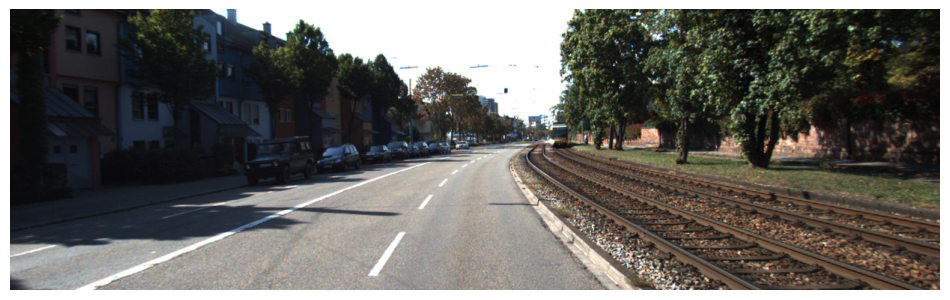

Ảnh mẫu 37:


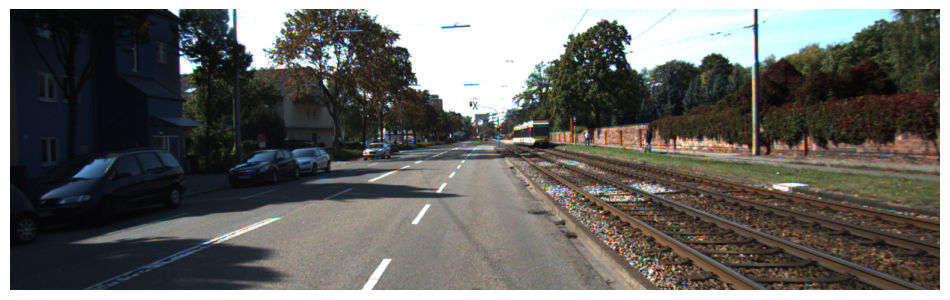

Ảnh mẫu 73:


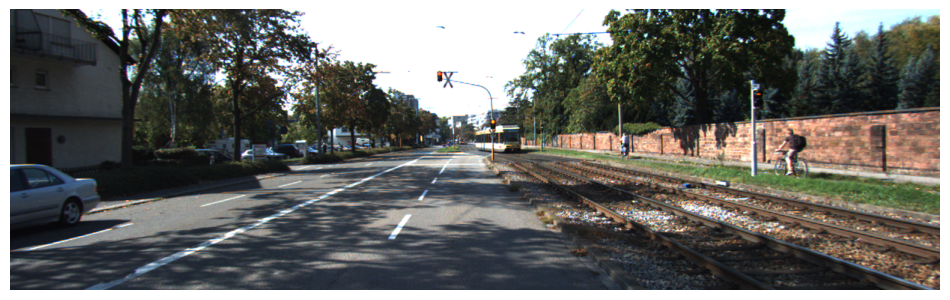


==== Sửa méo ảnh (Undistort) ====
So sánh ảnh gốc (trên) và ảnh đã sửa méo (dưới):

Ảnh đã được sửa méo và lưu tại: kitti_undistorted_result.png

==== Lưu kết quả hiệu chỉnh ====
Đã lưu kết quả hiệu chỉnh tại: kitti_calibration_result.npz

==== Xử lý và lưu nhiều ảnh (tùy chọn) ====
Đã lưu undistorted_images/kitti_undistorted_000.png
Đã lưu undistorted_images/kitti_undistorted_021.png
Đã lưu undistorted_images/kitti_undistorted_042.png
Đã lưu undistorted_images/kitti_undistorted_063.png
Đã lưu undistorted_images/kitti_undistorted_084.png

Đã xử lý và lưu 5 ảnh vào thư mục undistorted_images/

==== Hoàn tất hiệu chỉnh camera với tập dữ liệu KITTI ====


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import io

# ------------------------------
# Bước 1: Tải tập dữ liệu KITTI
# ------------------------------
print("==== Bắt đầu tải tập dữ liệu KITTI ====")

os.makedirs("kitti_data", exist_ok=True)

# tải file dữ liệu KITTI
url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip"
print(f"Đang tải tập dữ liệu từ: {url}")

response = urllib.request.urlopen(url)
zip_data = io.BytesIO(response.read())

with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall("kitti_data")

print("Đã tải và giải nén xong tập dữ liệu!")

# tải file hiệu chỉnh camera
calib_url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip"
print(f"Đang tải dữ liệu hiệu chuẩn từ: {calib_url}")

calib_response = urllib.request.urlopen(calib_url)
calib_zip_data = io.BytesIO(calib_response.read())

with zipfile.ZipFile(calib_zip_data, 'r') as zip_ref:
    zip_ref.extractall("kitti_data")

print("Đã tải và giải nén xong dữ liệu hiệu chuẩn!")


# ------------------------------
# Bước 2: Đọc dữ liệu hiệu chỉnh và ảnh
# ------------------------------

print("\n==== Đọc dữ liệu hiệu chỉnh và ảnh ====")

def read_kitti_calib(calib_file):
    with open(calib_file, 'r') as f:
        lines = f.readlines()

    calib_data = {}
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue

        parts = line.split(':', 1)
        if len(parts) != 2:
            continue

        key, value = parts
        key = key.strip()

        try:
            values = []
            for val in value.strip().split():
                try:
                    values.append(float(val))
                except ValueError:
                    continue

            if values:  
                calib_data[key] = np.array(values)
        except Exception as e:
            print(f"Bỏ qua trường {key}: {e}")

    # Kiểm tra xem có đủ dữ liệu hiệu chuẩn không
    required_keys = ['P0', 'P1', 'P2', 'P3']
    for key in required_keys:
        if key not in calib_data:
            print(f"Cảnh báo: Không tìm thấy key '{key}' trong file hiệu chuẩn")

    # Nếu P0-P3 tồn tại, reshape thành ma trận 3x4
    for key in required_keys:
        if key in calib_data and len(calib_data[key]) == 12:
            calib_data[key] = calib_data[key].reshape(3, 4)

    # Tạo ma trận nội tại và ma trận xoay-tịnh tiến
    result = {}

    # Thêm ma trận gốc vào kết quả
    for key, value in calib_data.items():
        result[key] = value

    # Tính toán ma trận nội tại từ P2 (camera màu bên trái)
    if 'P2' in calib_data and calib_data['P2'].shape == (3, 4):
        K2 = calib_data['P2'][:3, :3]
        result['K2'] = K2
    else:
        # Nếu không có P2, sử dụng ma trận nội tại mặc định
        print("Cảnh báo: Không tìm thấy ma trận P2 hợp lệ, sử dụng ma trận nội tại mặc định")
        result['K2'] = np.array([
            [718.856, 0, 607.1928],
            [0, 718.856, 185.2157],
            [0, 0, 1]
        ])
    return result

calib_file = "kitti_data/2011_09_26/calib_cam_to_cam.txt"

try:
    calib_data = read_kitti_calib(calib_file)
    if 'K2' in calib_data:
        camera_matrix = calib_data['K2']
        print("\nMa trận nội tại camera (từ file hiệu chỉnh KITTI):")
        print(camera_matrix)
    else:
        print("\nKhông tìm thấy ma trận nội tại trong file hiệu chỉnh.")
        print("Sử dụng ma trận nội tại mặc định cho camera KITTI:")
        camera_matrix = np.array([
            [718.856, 0, 607.1928],
            [0, 718.856, 185.2157],
            [0, 0, 1]
        ])
        print(camera_matrix)
except Exception as e:
    print(f"Lỗi khi đọc file hiệu chỉnh: {e}")
    print("Sử dụng ma trận nội tại mặc định cho camera KITTI:")
    camera_matrix = np.array([
        [718.856, 0, 607.1928],
        [0, 718.856, 185.2157],
        [0, 0, 1]
    ])
    print(camera_matrix)

# Lấy danh sách các ảnh từ camera 2 (left color camera)
image_dir = "kitti_data/2011_09_26/2011_09_26_drive_0001_sync/image_02/data"

if not os.path.exists(image_dir):
    print(f"Thư mục {image_dir} không tồn tại. Đang tìm kiếm thư mục ảnh...")
    kitti_root = "kitti_data"
    image_files = []
    for root, dirs, files in os.walk(kitti_root):
        if files and any(f.endswith(('.png', '.jpg')) for f in files):
            image_dir = root
            image_files = sorted([os.path.join(root, f) for f in files if f.endswith(('.png', '.jpg'))])
            print(f"Tìm thấy thư mục ảnh: {image_dir}")
            break
    if not image_files:
        print("Không tìm thấy ảnh nào trong dữ liệu đã tải. Đang tải một vài ảnh mẫu...")
        sample_urls = [
            "https://www.cvlibs.net/datasets/kitti/imgs/raw_data.png",
            "https://www.cvlibs.net/datasets/kitti/imgs/city_3.png",
            "https://www.cvlibs.net/datasets/kitti/imgs/road_3.png"
        ]
        os.makedirs("kitti_samples", exist_ok=True)
        image_files = []
        for i, url in enumerate(sample_urls):
            try:
                filename = f"kitti_samples/sample_{i+1}.png"
                urllib.request.urlretrieve(url, filename)
                image_files.append(filename)
                print(f"Đã tải ảnh mẫu {i+1}")
            except Exception as e:
                print(f"Không thể tải ảnh mẫu {i+1}: {e}")
else:
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])

print(f"\nTìm thấy {len(image_files)} ảnh")

if not image_files:
    print("CẢNH BÁO: Không tìm thấy ảnh nào!")
    dummy_img = np.zeros((375, 1242, 3), dtype=np.uint8)
    dummy_file = "kitti_data/dummy_image.png"
    cv2.imwrite(dummy_file, dummy_img)
    image_files = [dummy_file]
    print("Đã tạo ảnh giả để tiếp tục quá trình")

img = cv2.imread(image_files[0])
image_size = (img.shape[1], img.shape[0])
print(f"Kích thước ảnh: {image_size}")

# ------------------------------
# Bước 3: Ước tính hệ số méo ống kính
# ------------------------------

print("\n==== Ước tính hệ số méo ống kính ====")
# Vì KITTI không cung cấp hệ số méo ống kính, giả định nó gần bằng 0 (đã hiệu chỉnh)
dist_coeffs = np.zeros((5, 1))
print("Hệ số méo ống kính (giả định gần bằng 0 cho KITTI):")
print(dist_coeffs)

# ------------------------------
# Bước 4: Hiển thị một số ảnh mẫu
# ------------------------------

print("\n==== Hiển thị một số ảnh mẫu ====")
num_samples = min(3, len(image_files))
sample_indices = [i * (len(image_files) // num_samples) for i in range(num_samples)]

for idx in sample_indices:
    img_sample = cv2.imread(image_files[idx])
    img_rgb = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
    print(f"Ảnh mẫu {idx+1}:")
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# ------------------------------
# Bước 5: Sửa méo ảnh (Undistort)
# ------------------------------

print("\n==== Sửa méo ảnh (Undistort) ====")
img_idx = 0
img = cv2.imread(image_files[img_idx])
h, w = img.shape[:2]
new_cam_mtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_cam_mtx)

print("So sánh ảnh gốc (trên) và ảnh đã sửa méo (dưới):")
comparison = np.vstack((img, undistorted_img))
cv2.imshow("So sanh anh goc va anh da sua meo", comparison)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite('kitti_undistorted_result.png', undistorted_img)
print("\nẢnh đã được sửa méo và lưu tại: kitti_undistorted_result.png")

# ------------------------------
# Bước 6: Lưu kết quả hiệu chỉnh
# ------------------------------

print("\n==== Lưu kết quả hiệu chỉnh ====")
np.savez('kitti_calibration_result.npz',
         camera_matrix=camera_matrix,
         dist_coeffs=dist_coeffs,
         image_size=image_size)
print("Đã lưu kết quả hiệu chỉnh tại: kitti_calibration_result.npz")

# ------------------------------
# Bước 7: Xử lý nhiều ảnh (tùy chọn)
# ------------------------------

print("\n==== Xử lý và lưu nhiều ảnh (tùy chọn) ====")
os.makedirs("undistorted_images", exist_ok=True)
num_process = min(5, len(image_files))
step = max(1, len(image_files) // num_process)
process_indices = [i * step for i in range(num_process)]

for idx in process_indices:
    img_proc = cv2.imread(image_files[idx])
    undistorted = cv2.undistort(img_proc, camera_matrix, dist_coeffs, None, new_cam_mtx)
    output_filename = f"undistorted_images/kitti_undistorted_{idx:03d}.png"
    cv2.imwrite(output_filename, undistorted)
    print(f"Đã lưu {output_filename}")

print(f"\nĐã xử lý và lưu {len(process_indices)} ảnh vào thư mục undistorted_images/")

print("\n==== Hoàn tất hiệu chỉnh camera với tập dữ liệu KITTI ====")
